In [126]:
# import pandas and gurobi
import pandas as pd
from gurobipy import *
import numpy as np


In [127]:
# read in csv
r = pd.read_csv("/Users/zachwayne/Documents/GitHub/15093-project/2019_monthly_data/monthly_returns_2019.csv")
s = pd.read_csv("/Users/zachwayne/Documents/GitHub/15093-project/2019_monthly_data/sectors_2019.csv")
p = pd.read_csv("/Users/zachwayne/Documents/GitHub/15093-project/2019_monthly_data/monthly_prices_2019.csv")
cor = pd.read_csv("/Users/zachwayne/Documents/GitHub/15093-project/2019_monthly_data/corr_2019.csv")
cov = pd.read_csv("/Users/zachwayne/Documents/GitHub/15093-project/2019_monthly_data/cov_2019.csv")
vol = pd.read_csv("/Users/zachwayne/Documents/GitHub/15093-project/2019_monthly_data/monthly_volume_2019.csv")
cov = cov.drop(columns=['Unnamed: 0'])
s = s.drop(columns=['Symbol'])
p = p.drop(columns=['Date'])
r = r.drop(columns=['Date'])
cor = cor.drop(columns=['Unnamed: 0'])
vol = vol.drop(columns=['Date'])
# cast vol to float
vol = vol.astype(float)

In [125]:
# make model
stocks = len(s)
k = 20
T = 12
# total = array of size 12
total = np.zeros(T+1)
total[0] = 300000
portfolio = np.zeros((stocks, T))
obj = np.zeros(T+1)
obj2 = np.zeros(T+1)

for t in range(T): 
    m = Model('portfolio')

    # Add matrix variable for the stocks
    x = m.addMVar(stocks, lb = 0, ub =.3) 
    z = m.addVars(stocks, vtype=GRB.BINARY, name="z")
    b = m.addVars(stocks, vtype=GRB.INTEGER, lb=0, name="x")

    # Objective is to minimize risk (squared).  This is modeled using the
    # covariance matrix, which measures the historical correlation between stocks
    portfolio_risk = x @ np.matrix(cov) @ x
    ret = np.matrix(r.iloc[t]) @ x
    m.setObjective(portfolio_risk - ret, GRB.MINIMIZE)

    # Fix budget with a constraint
    m.addConstr(x.sum() == 1, 'budget')
    # return is at least 0.1
    m.addConstr(portfolio_risk <= 0.05, 'return')
    m.addConstrs((x[i] <= z[i] for i in range(stocks)), "w<=z")
    #m.addConstrs((b[i] >= z[i]*5 for i in range(stocks)), "b<=5")
    m.addConstrs((10000*x[i] >= z[i] for i in range(stocks)), "w>=z")
    m.addConstr(quicksum(z[i] for i in range(stocks)) == k, "k")
    m.addConstr(quicksum(b[i]*p.iloc[t,i] for i in range(stocks)) <= total[t], "budget")
    m.addConstrs((b[i] >= z[i] for i in range(stocks)), "x>=fvfav")
    m.addConstrs((x[i] == (b[i]*p.iloc[t,i])/total[t] for i in range(stocks)), "w")
    m.addConstrs((quicksum(z[i]*s.iloc[i,j] for i in range(stocks)) <= 5 for j in range(len(s.columns))), "sector")
    m.Params.MIPGap = 0.01

    m.optimize()
    
    obj[t] = portfolio_risk.getValue()
    obj2[t] = ret.getValue()

    # print optimal x
    for v in m.getVars():
        if v.x > 0 and v.varName[0] == 'x':
            total[t+1] += v.x*p.iloc[t+1,int(v.varName.replace("x[","").replace("]",""))]
    portfolio[:,t] = np.array([v.x for v in m.getVars() if v.varName[0] == 'C'])

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1922 rows, 1431 columns and 5724 nonzeros
Model fingerprint: 0xd3a78e4f
Model has 114003 quadratic objective terms
Model has 1 quadratic constraint
Variable types: 477 continuous, 954 integer (477 binary)
Coefficient statistics:
  Matrix range     [2e-05, 1e+04]
  QMatrix range    [1e-08, 1e-01]
  Objective range  [6e-04, 3e-01]
  QObjective range [2e-08, 2e-01]
  Bounds range     [3e-01, 1e+00]
  RHS range        [1e+00, 3e+05]
  QRHS range       [5e-02, 5e-02]
Presolve time: 0.41s
Presolved: 1922 rows, 1431 columns, 5724 nonzeros
Presolved model has 114003 quadratic objective terms
Presolved model has 1 quadratic constraint(s)
Variable types: 477 continuous, 954 integer (477 binary)

Root relaxation: objective -5.957814e-02, 3156 iterations, 0.27 seconds (0.26 work units)

    Nodes    |  

KeyboardInterrupt: 

In [18]:
#loop through total and print out the total value of the portfolio at each time step
for i in range(len(total)):
    if i == 0:
        print("Initial value: " + str(total[i]))
    else:
        print("Total value of portfolio at the end of month " + ": " + str(total[i]), " Risk: " + str(obj[i]), " Return: " + str(obj2[i]))

Initial value: 300000.0
Total value of portfolio at the end of month : 328270.38571739197  Risk: 0.014214509856993634  Return: 0.3931712079997304
Total value of portfolio at the end of month : 365358.7263126373  Risk: 0.018478152342178554  Return: 0.289970814162151
Total value of portfolio at the end of month : 382977.0702819824  Risk: 0.004153760205216026  Return: 0.17999939053802497
Total value of portfolio at the end of month : 396758.26734924316  Risk: 0.013233048213449056  Return: 0.31841967110213354
Total value of portfolio at the end of month : 339826.59131240845  Risk: 0.013394607280808064  Return: 0.24148533362371166
Total value of portfolio at the end of month : 355775.9987373352  Risk: 0.022706549216847286  Return: 0.30413273974786653
Total value of portfolio at the end of month : 356124.06023979187  Risk: 0.010177917005059376  Return: 0.2753401639651693
Total value of portfolio at the end of month : 358229.491355896  Risk: 0.004430429106516699  Return: 0.20217694461330013
T

Text(0, 0.5, 'Percentage of portfolio')

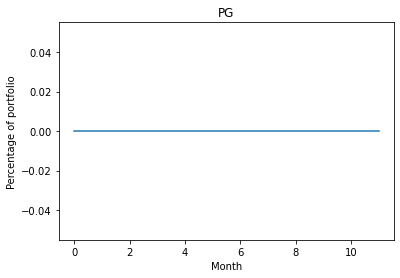

In [101]:
import matplotlib.pyplot as plt
stockPlot = r.columns.get_loc("PG")
plt.plot(portfolio[stockPlot,:])
# TITLE  = stock name
plt.title(p.columns[stockPlot])
plt.xlabel("Month")
plt.ylabel("Percentage of portfolio")

In [109]:
# 2x2 matrix of ones
ones = np.ones((2,2))
ones[0]

array([1., 1.])

In [21]:
#loop through total and print out the total value of the portfolio at each time step
for i in range(len(total)):
    if i == 0:
        print("Initial value: " + str(total[i]))
    else:
        print("Total value of portfolio at the end of month " + ": " + str(total[i]), " Risk: " + str(obj[i]), " Return: " + str(obj2[i]))

Initial value: 300000.0
Total value of portfolio at the end of month : 328251.64044189453  Risk: 0.014225850240788984  Return: 0.3931700739211469
Total value of portfolio at the end of month : 365456.65624427795  Risk: 0.01870394939012754  Return: 0.2901374606675258
Total value of portfolio at the end of month : 385000.42928886414  Risk: 0.004154416448851585  Return: 0.17996133232082556
Total value of portfolio at the end of month : 398842.50088500977  Risk: 0.02480057354972528  Return: 0.32581959369674796
Total value of portfolio at the end of month : 330258.4767360687  Risk: 0.013897937655148478  Return: 0.24176540281115272
Total value of portfolio at the end of month : 340871.6001739502  Risk: 0.02482288657765054  Return: 0.3045486121662927
Total value of portfolio at the end of month : 342490.4030199051  Risk: 0.01178534856652479  Return: 0.2767573180225144
Total value of portfolio at the end of month : 342541.7567329407  Risk: 0.004569811255027863  Return: 0.20227751759357362
Tota

In [128]:
# make model
stocks = len(s)
k = 10
T = 12
# total = array of size 12
total = np.zeros(T+1)
total[0] = 100000
portfolio = np.zeros((stocks, T))
inventoryT0 = np.zeros((stocks))
inventoryT1 = np.zeros((stocks))
obj = np.zeros(T+1)
obj2 = np.zeros(T+1)

for t in range(T): 
    m = Model('portfolio')

    # Add matrix variable for the stocks
    x = m.addMVar(stocks, lb = 0, ub = .5) 
    z = m.addVars(stocks, vtype=GRB.BINARY, name="z")
    b = m.addVars(stocks, vtype=GRB.INTEGER, lb=0, name="x")

    # Objective is to minimize risk (squared).  This is modeled using the
    # covariance matrix, which measures the historical correlation between stocks
    portfolio_risk = x @ np.matrix(cov) @ x
    ret = np.matrix(r.iloc[t]) @ x
    m.setObjective(ret, GRB.MAXIMIZE)

    # Fix budget with a constraint
    m.addConstr(x.sum() == 1, 'budget')
    # return is at least 0.1
    m.addConstr(portfolio_risk <= 0.05, 'return')
    m.addConstrs((x[i] <= z[i] for i in range(stocks)), "w<=z")
    #m.addConstrs((b[i] >= z[i]*5 for i in range(stocks)), "b<=5")
    m.addConstrs((10000*x[i] >= z[i] for i in range(stocks)), "w>=z")
    m.addConstr(quicksum(z[i] for i in range(stocks)) >= k, "k")
    m.addConstr(quicksum(b[i]*p.iloc[t,i] for i in range(stocks)) <= total[t], "budget")
    m.addConstrs((b[i] >= z[i] for i in range(stocks)), "x>=fvfav")
    m.addConstrs((x[i] == (b[i]*p.iloc[t,i])/(total[t]) for i in range(stocks)), "w")
    m.addConstrs((quicksum(z[i]*s.iloc[i,j] for i in range(stocks)) <= 4 for j in range(len(s.columns))), "sector")
    # difference between b[i] and inventoryT1[i] is less than v[i,t]
    m.addConstrs((b[i] - inventoryT1[i] <= .05*vol.iloc[t,i] for i in range(stocks)), "v")
    m.Params.MIPGap = 0.01

    # stocks we buy must have a corr[i,j] < 0.5
    m.addConstrs((z[i] + z[j] <= 1 for i in range(stocks) for j in range(stocks) if i != j and cor.iloc[i,j] > 0.3), "corr")

    m.optimize()
    
    obj[t] = portfolio_risk.getValue()
    obj2[t] = ret.getValue()
    if t == 0:
       #make inventoryT0 equal to all zeros
        inventoryT0 = np.zeros((stocks))
    else:
        inventoryT0 = inventoryT1.copy()
    # print optimal x
    for v in m.getVars():
        if v.varName[0] == 'x':
            inventoryT1[int(v.varName.replace("x[","").replace("]",""))] = v.x
            total[t+1] += v.x*p.iloc[t+1,int(v.varName.replace("x[","").replace("]",""))]
            if (abs(inventoryT0[int(v.varName.replace("x[","").replace("]",""))]-inventoryT1[int(v.varName.replace("x[","").replace("]",""))])) > 0:
                total[t+1] -= (8.9)
                # avg transaction cost
            
    portfolio[:,t] = np.array([v.x for v in m.getVars() if v.varName[0] == 'C'])
    

Set parameter MIPGap to value 0.01
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 116703 rows, 1431 columns and 234809 nonzeros
Model fingerprint: 0x7a149b7b
Model has 1 quadratic constraint
Variable types: 477 continuous, 954 integer (477 binary)
Coefficient statistics:
  Matrix range     [5e-05, 1e+04]
  QMatrix range    [1e-08, 1e-01]
  Objective range  [6e-04, 3e-01]
  Bounds range     [5e-01, 1e+00]
  RHS range        [1e+00, 7e+06]
  QRHS range       [5e-02, 5e-02]
Presolve removed 112183 rows and 2 columns
Presolve time: 1.99s
Presolved: 4520 rows, 1429 columns, 110253 nonzeros
Presolved model has 1 quadratic constraint(s)
Variable types: 475 continuous, 954 integer (477 binary)

Root relaxation: objective 7.252154e-02, 1872 iterations, 0.23 seconds (0.56 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Dept

In [129]:
#loop through total and print out the total value of the portfolio at each time step
for i in range(len(total)):
    if i == 0:
        print("Initial value: " + str(total[i]))
    else:
        print("Total value of portfolio at the end of month " + ": " + str(total[i]), " Risk: " + str(obj[i]), " Return: " + str(obj2[i]))

Initial value: 100000.0
Total value of portfolio at the end of month : 115113.21025276186  Risk: 0.022949896701796053  Return: 0.43445821207938096
Total value of portfolio at the end of month : 133262.07164154062  Risk: 0.019858885749805343  Return: 0.2906319961193227
Total value of portfolio at the end of month : 141111.010242653  Risk: 0.0041023727055306625  Return: 0.18785349378667096
Total value of portfolio at the end of month : 151381.9726474763  Risk: 0.01275405997221184  Return: 0.33497894188506594
Total value of portfolio at the end of month : 128039.27776460654  Risk: 0.022327142250856424  Return: 0.31504421589188136
Total value of portfolio at the end of month : 134948.84339294437  Risk: 0.034340189592372165  Return: 0.30076012106136873
Total value of portfolio at the end of month : 126367.63290252697  Risk: 0.019036276601571357  Return: 0.3530902562507782
Total value of portfolio at the end of month : 126505.69119625095  Risk: 0.00543343804433955  Return: 0.2142600814572123

In [130]:
# mean of r over rows
(total[-1]-100000)/100000

0.5174214293613433

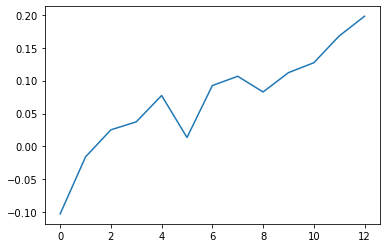

In [102]:

# geomentric mean of returns over time
# plot geometric mean of returns over time
plt.plot(np.cumprod(1+r.mean(axis=1))-1)

In [124]:
import plotly.graph_objects as go

result_returns = np.zeros(T+1)
for i in range(1,len(total)):
    result_returns[i] = (total[i]-total[i-1])/total[i-1]
# graph in plotly - plt.plot(np.cumprod(1+result_returns)-1)
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(0,T+1), y=np.cumprod(1+result_returns)-1, name='Portfolio'))
fig.add_trace(go.Scatter(x=np.arange(0,T+1), y=np.cumprod(1+r.mean(axis=1))-1, name='S&P 500'))
# labels
fig.update_layout(title='Our Portfolio\'s Returns compared to S&P 500', xaxis_title='Month', yaxis_title='Returns')
fig.show()

Text(0, 0.5, 'Percentage of portfolio')

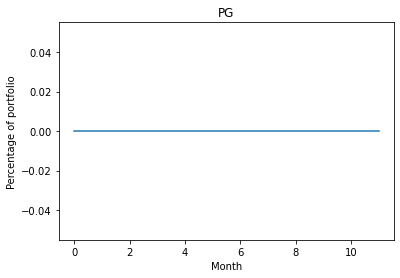

In [47]:
import matplotlib.pyplot as plt
stockPlot = r.columns.get_loc("PG")
plt.plot(portfolio[stockPlot,:])
# TITLE  = stock name
plt.title(p.columns[stockPlot])
plt.xlabel("Month")
plt.ylabel("Percentage of portfolio")

In [97]:
# graph every stock in portfolio on same graph in plotly
import plotly.graph_objects as go
fig = go.Figure()
for i in range(len(portfolio)):
    fig.add_trace(go.Scatter(x=np.arange(0,12), y=portfolio[i,:], name=p.columns[i]))
fig.show()
